MIT License

Copyright (c) 2024 Mohannad Shehadeh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

This notebook provides a [Julia](https://julialang.org/) model for a complete encoder–decoder pair for unterminated [Higher-Order Staircase Codes](https://arxiv.org/pdf/2312.13415) with extended Hamming component codes. For fast simulation, you should instead use [decsim-hosc](https://github.com/fkschischang/decsim) which is intended to simulate a statistically equivalent process, but orders of magnitude faster. 

THIS NOTEBOOK IS A PRELIMINARY VERSION THAT HAS YET TO BE THOROUGHLY COMMENTED AND VALIDATED.

In [1]:
# Required packages; install if missing
using DataStructures
using Dates
using Plots
using DelimitedFiles

In [2]:
include("GF2-LinAlg.jl");
include("L-one-two-DTSs.jl");
include("grab-DTS.jl");

We have a special choice of $L\times (M+1)$ delay values $0 = d_0^{(\ell)} < d_1^{(\ell)} < \cdots < d_M^{(\ell)}$ for 
$\ell \in \{0,1,\dots,L-1\}$. We further have that $\mathsf{SCOPE} = d_M^{(0)} > d_M^{(1)} > \cdots > d_M^{(L-1)}$. The optimal such values (minimizing encoding and decoding memory while guaranteeing [scattering](https://arxiv.org/pdf/2312.13415)) are extremely difficult to find in general except when $M\in\{1,2\}$ in which case there is an explicit construction. The optimal such delays for $M\in \{3,4\}$ were found for some values of $L$ in [Higher-Order Staircase Codes](https://arxiv.org/pdf/2312.13415) and are included in this repository. We also have
$M+1$ special permutations $\pi_k(i,j)$ for $k \in \{0,1,\dots,M\}$ where $i,j\in \{0,1,\dots,T-1\}$. Unlike the delays, these have an easy explicit algebraic construction. The matrix $B$ with entries $b_{(i,j)}$ permuted according to $\pi_k$ has entries given by $b_{\pi_k(i,j)}$ and is denoted by $\Pi_k(B)$. Moreover, we have $\Pi_0(B) = B$.

We have $T \times T$ blocks $B^{(n,\ell)}$ for $n\in\mathbb{Z}$ and $\ell \in \{0,1,\dots,L-1\}$ which 
are arranged into $T \times LT$ rectangles that are transmitted. The $n$th rectangle is given by:
$$
\big(B_{(n,L-1)}\; B_{(n,L-2)}\; \cdots\; B_{(n,0)}\big)
= 
\big(\text{ $T \times (LT-r)$ information bits} \;\big\vert\; \text{ $T \times r$ parity bits}\big)
$$

The encoding rule is as follows. The $n$th rectangle is adjoined *not* to $M$ previous rectangles, but to $M$ rectangles constructed from blocks taken from *different* previous rectangles and permuted to form the $T \times ((M+1)LT)$ matrix:
$$
\big(\Pi_M(B^{(n-d_M^{(L-1)},L-1)})\; \cdots\; \Pi_M(B^{(n-d_M^{(1)},1)})\; \Pi_M(B^{(n-d_M^{(0)},0)}) 
\;\big\vert\; 
\cdots 
\;\big\vert\; 
\Pi_1(B^{(n-d_1^{(L-1)},L-1)})\; \cdots\; \Pi_1(B^{(n-d_1^{(1)},1)})\; \Pi_1(B^{(n-d_1^{(0)},0)}) 
\;\big\vert\; 
B^{(n,L-1)}\; \cdots\; B^{(n,1)}\; B^{(n,0)}\big)
$$

This is labelled as the $(n-\mathsf{SCOPE})$th constraint span. The $n$th constraint span is thus that starting at the $n$th rectangle, ending in the $(n+\mathsf{SCOPE})$th rectangle, and 
involving only $(M+1)L$ blocks out of the $L(1+\mathsf{SCOPE})$ blocks contained in the $1+\mathsf{SCOPE}$ rectangles involved. 

If we consider block $B^{(n,\ell)}$, the $M+1$ involved constraint spans are the $(n-\mathsf{SCOPE}+d_i^{(\ell)})$th for $i \in \{0,1,\dots, M\}$.

If we have a decoding window (or circular buffer) of $W$ rectangles, we maintain a circular buffer of $W$ groups of $T$ syndromes corresponding to $W$ constraint spans. The first $W-\mathsf{SCOPE}$ of these correspond to complete constraint spans in the decoding window. The last $\mathsf{SCOPE}$ of these correspond to partial syndromes calculated from the portion
of the constraint spans that are in the decoding window.

You must choose $M$ to be less than or equal to the least prime factor of $T$ in this notebook. It is possible to have more flexibility with the values of $M$ and $T$ if required as illustrated [here](https://github.com/applecoffeecake/hosc-interleaver-maps) and you can easily implement it here by copying and adapting my Julia code from there. But I don't implement it here because I want to avoid the prime power finite field arithmetic involved.


In [3]:
# You must choose M to be less than or equal to the least prime factor of T
# to get a proper higher-order staircase code with the right error floor performance.
L = 5
T = 3
M = 2

# Load the matrix of delay values DTS. Currently supported L and M are:
# If M = 1: all L 
# If M = 2: all L
# If M = 3: all L up to 15
# If M = 4: all L up to 10 excluding 9
# If M = 5,6,7,8,9: L = 1
DTS = grabDTS(L,M)

SCOPE = maximum(DTS);

# Decoding window size in number of T x LT rectangles:
# Suggested value is 2*(1+SCOPE) to 5*(1+SCOPE)
W = 2*(1+SCOPE)

# Number of decoding iterations
ITERS = 4

m = ceil(Int64, log2(L*T*(M+1)))
s = 2^m - (M+1)*L*T;
n = (M+1)*L*T;
k = n-(m+1);
@assert m+1 <= L*T
# @assert W >= 1+SCOPE
println("L = $L")
println("T = $T")
println("M = $M")
println("SCOPE = $SCOPE")
println("W = $W rectangles = $(W*T*L*T/1e6) Mbits" )
println("rate = $(1-(m+1)/(L*T))")
println("component code dimension/length k/n = $k/$n")
println("number of parity bits (or parity columns in a block) m+1 = $(m+1)")

L = 5
T = 3
M = 2
SCOPE = 15
W = 32 rectangles = 0.00144 Mbits
rate = 0.5333333333333333
component code dimension/length k/n = 38/45
number of parity bits (or parity columns in a block) m+1 = 7


In [4]:
# # CREATE C language static array DTS definitions for use externally

# L_M_SET = [(L,1) for L in 1:40];
# L_M_SET = [L_M_SET; [(L,2) for L in 1:40]];
# L_M_SET = [L_M_SET; [(L,3) for L in 1:15]];
# L_M_SET = [L_M_SET; [(L,4) for L in [1,2,3,4,5,6,7,8,10]]];
# C_DTS_config = "";
# for lmpair in L_M_SET
#     local L = lmpair[1];
#     local M = lmpair[2];
#     local DTS = grabDTS(L,M);
#     C_DTS_config *= 
#     (L==1 && M==1 ? "#" : "#el")* 
#     "if (L == $L && M == $M)
#         static const int DTS[L][M+1] = " *
#         "{"*prod(["{"*prod(string.(DTS[j,:]) .* [i == M+1 ? "" : "," for i in 1:M+1])*"}" for j in 1:L] .* 
#     [i == L ? "" : "," for i in 1:L])*"};
#         #define SCOPE $(maximum(DTS))
# "
# end
# C_DTS_config *= "#endif"
# write("C_DTS_config.txt",C_DTS_config);

In [5]:
# The following creates a systematic extended Hamming code 
# generator matrix G, parity-check matrix H, its transpose Ht,
# and the parity/non-identity portion of the generator matrix P
# This is a special choice of systematic extended Hamming code
# with a LUT-free decoding method described in the Higher-Order
# Staircase Codes paper.

# m a b ainv
special_eHamming = 
[
3 1 1 1;  
4 3 0  11;
5 3 0  11;
6 3 3  43;
7 5 5  77;
8 9 11  57;
9 19 19  27;
10 27 27  531;
11 53 53  541;
12 89 89  2025;
13 163 170  4875;
14 301 308  13989;
15 553 553  14873;
16 1065 1155 55321;
]
if (m < 3 || m > 16)
    throw("Unsupported m!")
end
a = special_eHamming[m-3+1,2]
b = special_eHamming[m-3+1,3] + a*s
ainv = special_eHamming[m-3+1,4]
mask = (1<<m)-1
minus_b = (1<<m)-b

synFromErrorloc(x) = (((a*x+b)&mask)<<1)+1
errorlocFromSyn(x) = (ainv*((x>>1)+minus_b))&mask

H = zeros(Int64,m+1,0)
for i in 0:n-1
    H = hcat(H,reverse(digits(synFromErrorloc(i),base=2,pad=m+1))) 
end

@assert [errorlocFromSyn(synFromErrorloc(x)) for x in 0:n-1] == 0:n-1
@assert [synFromErrorloc(errorlocFromSyn(2*x+1)) for x in 0:n-1] == 2 .* (0:n-1) .+ 1

G = RREF(dual(H));

Id_kk = Int64.(ones(k,k)^0)
@assert G[1:k,1:k] == Id_kk;
@assert sum(mod.(G*transpose(H),2)) == 0;
P = G[:,k+1:n];
Ht = transpose(H);

Note that a more memory-efficient encoder architecture is possible than the one modeled here where the memory requirement is proportional to [*sum-of-lengths* rather than *scope*](https://arxiv.org/pdf/2312.13415).

In [6]:
TX_buffer = CircularBuffer{Matrix{Int64}}(W); # TX buffer for error counting
RX_buffer = CircularBuffer{Matrix{Int64}}(W); # Decoder buffer
Syn_buffer = CircularBuffer{Matrix{Int64}}(W); # Decoder buffer
ENC_buffer = CircularBuffer{Matrix{Int64}}(SCOPE); # Encoder buffer

In [7]:
function reset_buffers()
    for i in 1:W
        push!(TX_buffer, zeros(Int64,T,L*T))
        push!(RX_buffer, zeros(Int64,T,L*T))
        push!(Syn_buffer, zeros(Int64,T,m+1))
    end
    for i in 1:SCOPE
        push!(ENC_buffer, zeros(Int64,T,L*T))
    end
end;
reset_buffers();

In [8]:
# l = 0,1,...,M

# π_1(l,i,j) = l == 0 ? i : (j-1)+1;
# π_2(l,i,j) = l == 0 ? j : mod((i-1)+(l-1)*(j-1), T) + 1;
# π_inv_1(l,i,j) = l == 0 ? i : mod(-(l-1)*(i-1) + (j-1), T) + 1;
# π_inv_2(l,i,j) = l == 0 ? j : (i-1) + 1;

π_1(l,i,j) = l == 0 ? i : mod.(-(l-1)*(i-1) + (j-1), T) + 1;
π_2(l,i,j) = l == 0 ? j : mod.((1-(l-1)^2)*(i-1) + (l-1)*(j-1), T) + 1;
π_inv_1(l,i,j) = l == 0 ? i : mod.(-(l-1)*(i-1) + (j-1), T) + 1;
π_inv_2(l,i,j) = l == 0 ? j : mod.((1-(l-1)^2)*(i-1) + (l-1)*(j-1), T) + 1;

In [9]:
Π(l,B) = [B[π_1(l,i,j), π_2(l,i,j)] for i in 1:T, j in 1:T];
Π_inv(l,B) = [B[π_inv_1(l,i,j), π_inv_2(l,i,j)] for i in 1:T, j in 1:T];

In [10]:
TEST_MAT = [j + T*i + 1 for i in 0:T-1, j in 0:T-1];
@assert sum([Π_inv(l,Π(l,TEST_MAT)) == TEST_MAT for l in 0:M]) == M+1
@assert sum([Π(l,Π_inv(l,TEST_MAT)) == TEST_MAT for l in 0:M]) == M+1

In [11]:
# Encode a uniformly random T x LT-(m+1) info rectangle, push T x LT result to ENC_buffer
function encode()
    B_info = rand(0:1,T,L*T-(m+1));
    B_parity = B_info*P[k-(L*T-(m+1)-1):k,:]
    for u in 1:M # delay/perm index
        for ℓ in 0:L-1 # class index
            B_parity += Π(u,ENC_buffer[end+1-DTS[ℓ+1,u+1]][:,1+(L-ℓ-1)*T:T+(L-ℓ-1)*T])*P[n-T+1-T*(L*u+ℓ):n-T*(L*u+ℓ),:]
        end
    end
    B = [B_info mod.(B_parity, 2)];
    push!(ENC_buffer, B)
end;

In [12]:
# Push clean copy of newest rectangle in ENC_buffer to TX_buffer
# Push a noisy copy to RX_buffer with crossover probability p
# Push an all zero T x (m+1) group of partial syndromes to Syn_buffer 
function transmit(p) 
    push!(TX_buffer, ENC_buffer[end])
    push!(RX_buffer, ENC_buffer[end] .⊻ (rand(T,L*T) .<= p))
    push!(Syn_buffer, zeros(Int64,T,m+1))
end;

In [13]:
# Update update M + 1 partial syndromes going as far back as SCOPE from
# the end of the syndrome buffer and completing one syndrome group
function update_Syn()
    for u in 0:M # delay/perm index
        for ℓ in 0:L-1 # class index
            Syn_buffer[end-SCOPE+DTS[ℓ+1,u+1]] .⊻= mod.(Π(u,RX_buffer[end][:,1+(L-ℓ-1)*T:T+(L-ℓ-1)*T])*Ht[n-T+1-T*(L*u+ℓ):n-T*(L*u+ℓ),:],2)
        end
    end
end;

In [14]:
function flip(rect, ℓ, i, j)
    RX_buffer[rect][i, (L-1-ℓ)*T + j] ⊻= 1
    for u = M:-1:0
        if rect-SCOPE+DTS[ℓ+1,u+1] <= 0 
            break;
        end
        i_perm, j_perm = π_inv_1(u,i,j), π_inv_2(u,i,j)
        Syn_buffer[rect-SCOPE+DTS[ℓ+1,u+1]][i_perm,:] .⊻= Ht[((M-u)*L+(L-1-ℓ))*T+j_perm,:] 
    end
end;

In [15]:
# count_errors() = sum(TX_buffer[1][:,1:S-(m+1)] .!= RX_buffer[1][:,1:S-(m+1)]);
count_errors() = sum(TX_buffer[1] .!= RX_buffer[1]);

In [16]:
integer_basis = [2^i for i in m:-1:0]';
function sweep()
    for c in (W-SCOPE):-1:1
        for i in 1:T
            if Syn_buffer[c][i,m+1] != 0 
                errorloc = errorlocFromSyn(integer_basis*Syn_buffer[c][i,:]) + 1;
                if errorloc <= n
                    j_rect = (errorloc-1)%(L*T) + 1
                    perm = M - div(errorloc-1, L*T)
                    ℓ = L-1-div(j_rect-1, T);
                    j = (j_rect-1)%T + 1;
                    flip(c+SCOPE-DTS[ℓ+1,perm+1], ℓ, π_1(perm, i, j), π_2(perm, i, j))
                end
            end          
        end
    end
end;

In [17]:
# Specify vector ps of crossover probabilities to simulate
# and vector TRIALS of respective numbers of trials for each crossover probability
# ps = [2,3,4,5,6,7]*1e-2
ps = [2.5,3,3.5]*1e-2
# ps = [3e-3]
TRIALS = Int64(1e6)*ones(Int64,length(ps))
display(ps')
display(TRIALS')

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 0.025  0.03  0.035

1×3 adjoint(::Vector{Int64}) with eltype Int64:
 1000000  1000000  1000000

In [18]:
tot = sum(TRIALS); # Total number of trials for progress tracking
percent_increment = round(Int64,tot/100) == 0 ? 1 : round(Int64,tot/100);

In [19]:
BERs = zeros(length(ps))
err_cts = zeros(Int64,length(ps))
tracker = 0
t_0 = now()
for point in 1:length(ps)
    reset_buffers();
    for trial in 1:TRIALS[point]   
        tracker += 1
        if tracker%percent_increment == 0
            percentage = round(Int64,tracker/tot*100)
            if percentage%1 == 0
                println("Progress: $percentage%")
                println("Errors for parameter p = $(ps[point]): $(err_cts[point])")
            end
        end
        encode();
        transmit(ps[point]);
        update_Syn();
        for iter in 1:ITERS
            sweep();
        end
        # Delay of W before starting error counting
        if trial > W
            err_cts[point] += count_errors();
        end     
    end
end
t_1 = now()

Progress: 1%
Errors for parameter p = 0.025: 25
Progress: 2%
Errors for parameter p = 0.025: 77
Progress: 3%
Errors for parameter p = 0.025: 106
Progress: 4%
Errors for parameter p = 0.025: 160
Progress: 5%
Errors for parameter p = 0.025: 188
Progress: 6%
Errors for parameter p = 0.025: 223
Progress: 7%
Errors for parameter p = 0.025: 245
Progress: 8%
Errors for parameter p = 0.025: 273
Progress: 9%
Errors for parameter p = 0.025: 295
Progress: 10%
Errors for parameter p = 0.025: 324
Progress: 11%
Errors for parameter p = 0.025: 338
Progress: 12%
Errors for parameter p = 0.025: 354
Progress: 13%
Errors for parameter p = 0.025: 385
Progress: 14%
Errors for parameter p = 0.025: 419
Progress: 15%
Errors for parameter p = 0.025: 431
Progress: 16%
Errors for parameter p = 0.025: 443
Progress: 17%
Errors for parameter p = 0.025: 463
Progress: 18%
Errors for parameter p = 0.025: 516
Progress: 19%
Errors for parameter p = 0.025: 542
Progress: 20%
Errors for parameter p = 0.025: 579
Progress: 2

2024-06-18T21:37:55.077

In [20]:
K = T*(L*T-(m+1));
println("Simulation duration in different units:")
println(round((t_1 - t_0), Dates.Second(1)))
println(round((t_1 - t_0), Dates.Minute(1)))
println(round((t_1 - t_0), Dates.Hour(1)))
println()
dur_in_ms = (t_1 - t_0).value
dur_in_ms_avg = (dur_in_ms/tot)
println("$tot trials or blocks transmitted")
println("$(tot*K*1e-6) Mbits transmitted")
println("$dur_in_ms_avg milliseconds per trial")
throughput = K/dur_in_ms_avg/1e-3/1e6
println("throughput: $throughput Mbit/s")

Simulation duration in different units:
384 seconds
6 minutes
0 hours

3000000 trials or blocks transmitted
72.0 Mbits transmitted
0.128086 milliseconds per trial
throughput: 0.18737410802117327 Mbit/s


In [21]:
err_cts'

1×3 adjoint(::Vector{Int64}) with eltype Int64:
 913  8280  59387

In [22]:
# 1.0 ./ ((TRIALS .- W)*K)'

In [23]:
ps'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 0.025  0.03  0.035

In [24]:
BERs = err_cts ./ ((TRIALS .- W)*K);
BERs'

1×3 adjoint(::Vector{Float64}) with eltype Float64:
 3.80429e-5  0.000345011  0.00247454

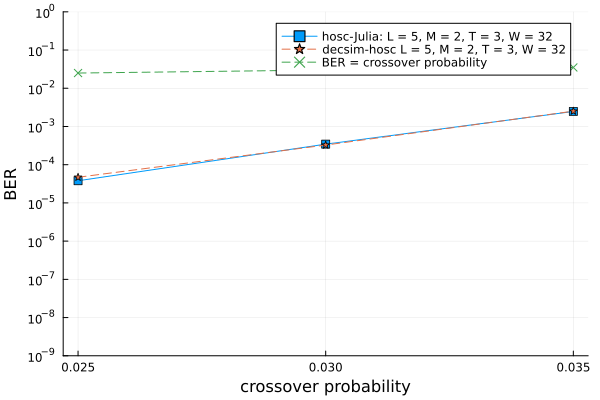

In [25]:
plot(ps, BERs, marker=:rect, yaxis=:log, label="hosc-Julia: L = $L, M = $M, T = $T, W = $W")
plot!([2.5,3,3.5]*1e-2,[4.68765e-05,0.00032651,0.00251479],mark=:s,linestyle=:dash,label="decsim-hosc L = 5, M = 2, T = 3, W = 32")
plot!(ps,ps,marker=:x,line=:dash,label="BER = crossover probability")
ylims!(1e-9,1e-0)
yticks!([10.0^(-i) for i in 0:9])
ylabel!("BER")
xticks!(ps)
xlabel!("crossover probability")
